In [1]:
import os
import joblib
from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import rasterio
from rasterio.transform import from_origin
from rasterio.transform import rowcol

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score

def normalized_gini(y_pred, y_true):
    """
    Computes the normalized Gini coefficient.

    Parameters:
    -----------
    y_pred : array-like
        The predicted values (e.g., model predictions).
    y_true : array-like
        The true target values.

    Returns:
    --------
    float
        The normalized Gini coefficient.
    """
    def sum_gini(a_pred, a_true):
        # Sort true values by descending predicted values
        order = np.argsort(-a_pred)
        a_true_sorted = a_true[order]
        
        # Construct the random cumulative array
        n = len(a_pred)
        random_cum = np.arange(1, n+1) / n
        
        # Calculate the Lorentz curve (cumulative) for the sorted true values
        lorentz = np.cumsum(a_true_sorted) / np.sum(a_true_sorted)
        
        # Gini is the area between the Lorentz curve and the uniform distribution
        return np.sum(lorentz - random_cum)

    return sum_gini(np.array(y_pred).astype(int), np.array(y_true).astype(int)) / sum_gini(np.array(y_true).astype(int), np.array(y_true).astype(int))


In [2]:
model_dir = 'models/production'
opt_dir = 'results/optimization'

study = joblib.load(os.path.join(opt_dir, "study.pkl"))
trial = study.best_trial

params = trial.params

lidar_path_2019 = 'data/raster/lidar_products/2019_lidar_cover.tif'
lidar_path_2020 = 'data/raster/lidar_products/2020_lidar_cover.tif'

#rap data (predictor)
rap_path = 'data/raster/rap/woody_cover_{YEAR}.tif'

#static terrain predictors
dem_path = 'data/raster/ned/ned.tif'
slope_path = 'data/raster/terrain/slope.tif'
hli_path = 'data/raster/terrain/hli.tif'
tpi_path = f'data/raster/terrain/tpi_{params["tpi_ngb"]}.tif'
twi_path = 'data/raster/terrain/twi.tif'

test_pts = gpd.read_file('data/vector/test_points.geojson')
train_pts = gpd.read_file('data/vector/train_points.geojson')
test_pts['set'] = 'test'
train_pts['set'] = 'train'

pts = pd.concat([test_pts, train_pts])

with rasterio.open(dem_path) as src:
    dem = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]

with rasterio.open(slope_path) as src:
    slope = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]

with rasterio.open(hli_path) as src:
    hli = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]

with rasterio.open(tpi_path) as src:
    tpi = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]

with rasterio.open(twi_path) as src:
    twi = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]

X = pd.DataFrame({
    'x_coord': pts.geometry.x,
    'y_coord': pts.geometry.y,
    'rap': None,
    'dem': dem, 
    'slope': slope,
    'hli': hli,
    'tpi': tpi,
    'twi': twi,
})

In [17]:
def rasterize_preds(template, target_path, preds, x_coords, y_coords):
    """
    Rasterize prediction points directly onto the template raster grid.
    The output raster bounds are cropped to the spatial extent of the input coordinates,
    preserving all template metadata.

    Parameters
    ----------
    template : str
        Path to the template raster file.
    target_path : str
        Path where the output raster will be saved.
    preds : array-like
        Prediction values to rasterize, length must match x_coords/y_coords.
    x_coords : array-like
        X coordinates (in same CRS as template) of the prediction points.
    y_coords : array-like
        Y coordinates (in same CRS as template) of the prediction points.
    """
    if len(preds) == 0 or len(x_coords) == 0 or len(y_coords) == 0:
        raise ValueError("No prediction points provided.")

    if not (len(preds) == len(x_coords) == len(y_coords)):
        raise ValueError("preds, x_coords, and y_coords must have the same length.")

    x_min, x_max = np.min(x_coords), np.max(x_coords)
    y_min, y_max = np.min(y_coords), np.max(y_coords)

    with rasterio.open(template) as src:
        meta = src.meta.copy()
        data = src.read(1)
        template_transform = src.transform
        crs = src.crs

    meta['nodata'] = 255
    data[:] = meta['nodata']

    for pred, x, y in zip(preds, x_coords, y_coords):
        row, col = rowcol(template_transform, x, y)
        if 0 <= row < data.shape[0] and 0 <= col < data.shape[1]:
            data[row, col] = pred
        else:
            print(f"Warning: ({x}, {y}) is outside the template coverage.")

    upper_left_row,  upper_left_col  = rowcol(template_transform, x_min, y_max)
    lower_right_row, lower_right_col = rowcol(template_transform, x_max, y_min)

    row_start = min(upper_left_row, lower_right_row)
    row_stop  = max(upper_left_row, lower_right_row)
    col_start = min(upper_left_col, lower_right_col)
    col_stop  = max(upper_left_col, lower_right_col)

    row_start = max(row_start, 0)
    col_start = max(col_start, 0)
    row_stop  = min(row_stop, data.shape[0] - 1)
    col_stop  = min(col_stop, data.shape[1] - 1)

    cropped_data = data[row_start:row_stop+1, col_start:col_stop+1]

    origin_x, origin_y = rasterio.transform.xy(template_transform, row_start, col_start)
    pixel_width = template_transform.a
    pixel_height = template_transform.e

    new_transform = from_origin(origin_x, origin_y, abs(pixel_width), abs(pixel_height))

    meta.update({
        'height': cropped_data.shape[0],
        'width': cropped_data.shape[1],
        'transform': new_transform,
        'crs': crs
    })

    with rasterio.open(target_path, 'w', **meta) as dst:
        dst.write(cropped_data, 1)

def predict_year(year, lgb_mod, gam_mod, inputs):
    d = inputs.copy()

    #select cols: rap, dem, slope, hli, tpi, twi
    X_data = d[['rap', 'dem', 'slope', 'hli', 'tpi', 'twi']]
    x_coords = d['x_coord']
    y_coords = d['y_coord']

    with rasterio.open(rap_path.replace('{YEAR}', str(year))) as src:
        rap = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]
        X_data['rap'] = rap

    #predict
    preds = lgb_mod.predict(X_data)
    preds_final = gam_mod.predict(preds.reshape(-1, 1))
    preds_final = np.clip(preds_final, 0, 100)
    
    return preds_final, x_coords, y_coords


In [18]:
years = range(1986, 2024)
output_dir = 'data/raster/predictions'
os.makedirs(output_dir, exist_ok=True)

lgb_mod = joblib.load(os.path.join(model_dir, f'lgb.pkl'))
gam_mod = joblib.load(os.path.join(model_dir, f'gam.pkl'))

def process_year(year):
    preds, x_coords, y_coords = predict_year(year, lgb_mod, gam_mod, X)
    rasterize_preds(lidar_path_2019, os.path.join(output_dir, f'{year}.tif'), preds, x_coords, y_coords)

Parallel(n_jobs=-1)(delayed(process_year)(year) for year in years)

/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_49491/1823065444.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_49491/1823065444.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_49491/1823065444.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [19]:
pred_path_2020 = 'data/raster/predictions/2020.tif'
rap_path_2020 = 'data/raster/rap/woody_cover_2020.tif'

test_pts = pts[pts['set'] == 'test'].copy()
with rasterio.open(lidar_path_2020) as src:
    test_pts['lidar_2020'] = [int(x[0]) if x[0] is not None else None for x in src.sample([(p.x, p.y) for p in test_pts.geometry])]

with rasterio.open(rap_path_2020) as src:
    test_pts['rap_2020'] = [int(x[0]) if x[0] is not None else None for x in src.sample([(p.x, p.y) for p in test_pts.geometry])]

with rasterio.open(pred_path_2020) as src:
    test_pts['pred_2020'] = [int(x[0]) if x[0] is not None else None for x in src.sample([(p.x, p.y) for p in test_pts.geometry])]

/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_49491/3774823741.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_xticklabels([0, 10, 20, 30, 40, '50+'])
/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_49491/3774823741.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


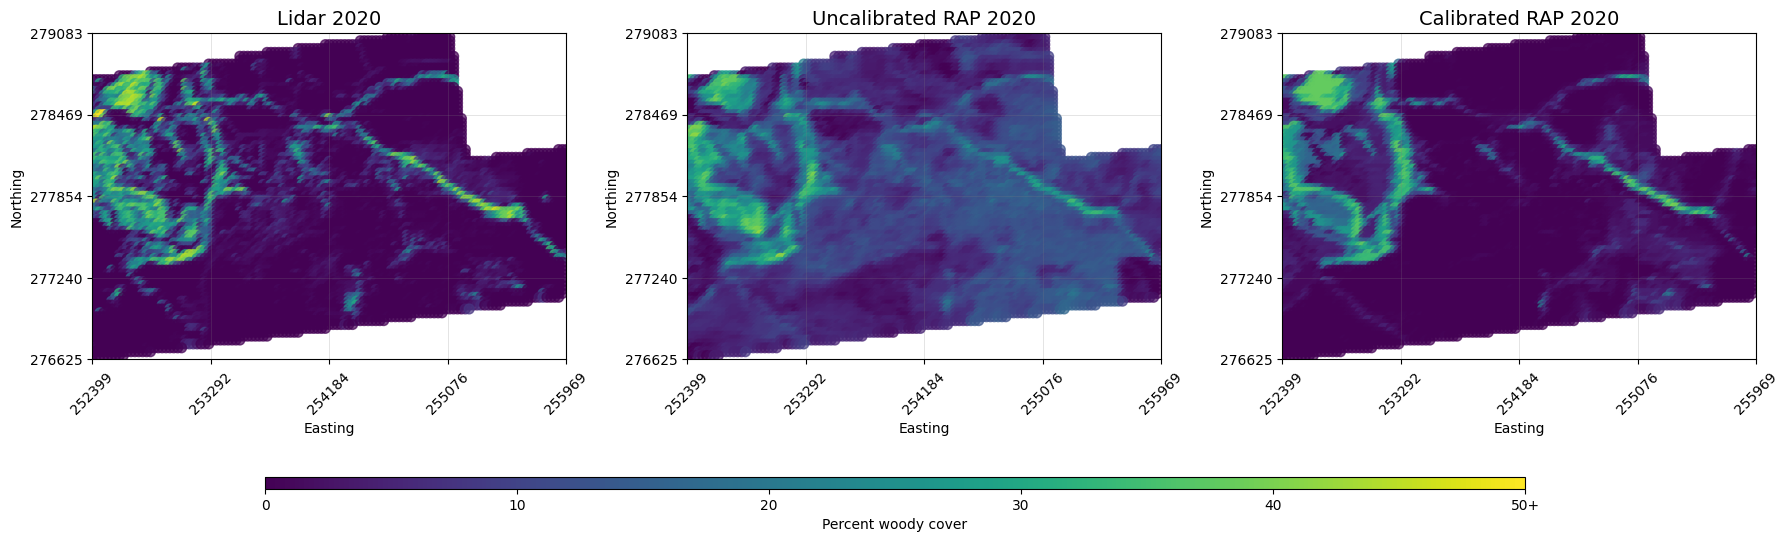

In [32]:
# Define the variables to plot
variables = ['lidar_2020', 'rap_2020', 'pred_2020']
variable_labels = {
    'lidar_2020': 'Lidar 2020',
    'rap_2020': 'Uncalibrated RAP 2020',
    'pred_2020': 'Calibrated RAP 2020'
}

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6),
                         subplot_kw={'aspect': 'equal'}, constrained_layout=False)

# Define the color normalization and colormap
norm = colors.Normalize(vmin=0, vmax=100)
cmap = plt.cm.viridis

for idx, var in enumerate(variables):
    ax = axes[idx]
    
    # Plot the points, colored by the variable
    scatter = test_pts.plot(column=var, ax=ax, cmap=cmap,
                            markersize=50, alpha=0.7, legend=False, norm=norm)
    
    # Set titles and labels
    ax.set_title(f'{variable_labels[var]}', fontsize=14)
    
    # Add x and y coordinates as ticks
    x_min, x_max = test_pts.geometry.x.min(), test_pts.geometry.x.max()
    y_min, y_max = test_pts.geometry.y.min(), test_pts.geometry.y.max()
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Set ticks at regular intervals
    x_ticks = np.linspace(x_min, x_max, 5)
    y_ticks = np.linspace(y_min, y_max, 5)
    
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    
    # Format tick labels without commas
    ax.set_xticklabels([f'{x:.0f}' for x in x_ticks], rotation=45)
    ax.set_yticklabels([f'{y:.0f}' for y in y_ticks])
    
    # Add grey grid
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Label axes
    ax.set_xlabel('Easting', fontsize=10)
    ax.set_ylabel('Northing', fontsize=10)

# Add a single colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percent woody cover')
cbar.ax.set_xticklabels([0, 10, 20, 30, 40, '50+'])

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
path_to_production_maps = 'results/figures/test_set_predictions.png'
plt.savefig(path_to_production_maps, dpi=300)

plt.show()

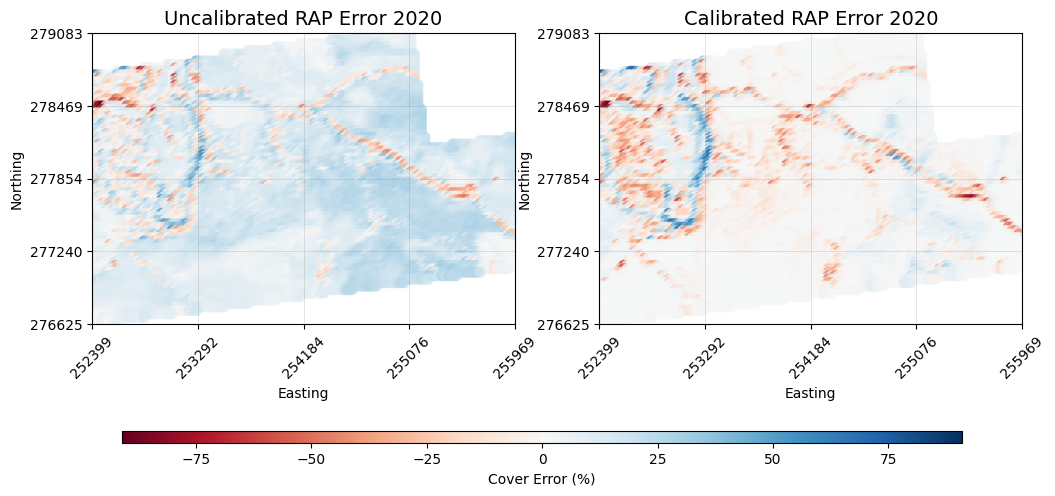

In [41]:
test_pts['diff_rap_2020'] = test_pts['rap_2020'] - test_pts['lidar_2020']
test_pts['diff_pred_2020'] = test_pts['pred_2020'] - test_pts['lidar_2020']

# Define the years and variables to plot
years = [2020]
variables = ['diff_rap', 'diff_pred']
variable_labels = {
    'diff_rap': 'Uncalibrated RAP Error 2020',
    'diff_pred': 'Calibrated RAP Error 2020'
}

# Create figure with subplots
fig, axes = plt.subplots(1, len(variables), figsize=(12, 6))

# Ensure axes is a list even if there's only one subplot
if len(variables) == 1:
    axes = [axes]

for col, var in enumerate(variables):
    ax = axes[col]
    
    # Define the column to plot
    column = f'{var}_{years[0]}'
    
    # Determine min and max for symmetric colorbar
    vmin = test_pts[column].min()
    vmax = test_pts[column].max()
    v_absmax = max(abs(vmin), abs(vmax))
    
    # Plot the points, colored by the variable
    scatter = test_pts.plot(column=column, ax=ax, cmap='RdBu',  # Divergent colormap
                            vmin=-v_absmax, vmax=v_absmax,  # Symmetric colorbar
                            markersize=50, alpha=0.7, legend=False)
    
    # Set titles and labels
    ax.set_title(f'{variable_labels[var]}', fontsize=14)
    ax.set_xlabel('Easting', fontsize=10)
    ax.set_ylabel('Northing', fontsize=10)
    
    # Get the bounds of the points
    x_min, x_max = test_pts.geometry.x.min(), test_pts.geometry.x.max()
    y_min, y_max = test_pts.geometry.y.min(), test_pts.geometry.y.max()
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Set ticks at regular intervals
    x_ticks = np.linspace(x_min, x_max, 5)
    y_ticks = np.linspace(y_min, y_max, 5)
    
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    
    # Format tick labels without commas
    ax.set_xticklabels([f'{x:.0f}' for x in x_ticks], rotation=45)
    ax.set_yticklabels([f'{y:.0f}' for y in y_ticks])
    
    # Add grey grid
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5, alpha=0.3)

# Add a single colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
norm = colors.Normalize(vmin=-v_absmax, vmax=v_absmax)
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Cover Error (%)')

# Set aspect ratio and limits for all subplots
for ax in axes:
    ax.set_aspect('equal')
    ax.set_ylim(y_min, y_max)

plt.subplots_adjust(bottom=0.2)
path_to_error_maps = 'results/figures/test_error_maps.png'
plt.savefig(path_to_error_maps, dpi=300)

plt.show()

/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_49491/974653377.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


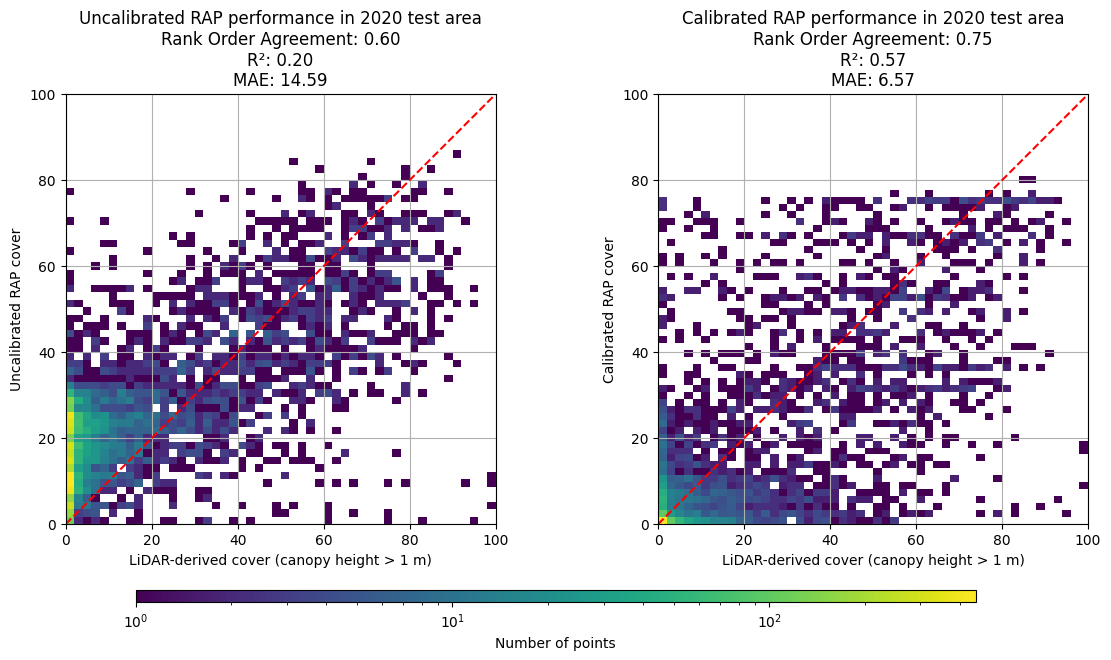


Uncalibrated RAP Metrics:
Rank Order Agreement: 0.599
R2: 0.202
MAE: 14.591

Calibrated RAP Metrics:
Rank Order Agreement: 0.753
R2: 0.567
MAE: 6.574


In [40]:
year = 2020

score_rap_lidar_mae = mean_absolute_error(
    test_pts[f'lidar_{year}'], 
    test_pts[f'rap_{year}']
)
score_rap_lidar_r2 = r2_score(
    test_pts[f'lidar_{year}'],
    test_pts[f'rap_{year}']
)
score_rap_lidar_normalized_gini = normalized_gini(
    test_pts[f'lidar_{year}'],
    test_pts[f'rap_{year}']
)

score_pred_lidar_mae = mean_absolute_error(
    test_pts[f'lidar_{year}'],
    test_pts[f'pred_{year}']
)
score_pred_lidar_r2 = r2_score(
    test_pts[f'lidar_{year}'],
    test_pts[f'pred_{year}']
)
score_pred_lidar_normalized_gini = normalized_gini(
    test_pts[f'lidar_{year}'],
    test_pts[f'pred_{year}']
)

fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(12, 6))

# Uncalibrated RAP vs LiDAR (2020)
h = axes[0].hist2d(
    test_pts[f'lidar_{year}'], 
    test_pts[f'rap_{year}'], 
    bins=50, cmap='viridis', norm=colors.LogNorm()
)

axes[0].set_xlabel(f'LiDAR-derived cover (canopy height > 1 m)')
axes[0].set_ylabel('Uncalibrated RAP cover')
axes[0].set_title(f'Uncalibrated RAP performance in 2020 test area\nRank Order Agreement: {score_rap_lidar_normalized_gini:.2f}\nR²: {score_rap_lidar_r2:.2f}\nMAE: {score_rap_lidar_mae:.2f}')
axes[0].grid(True)
min_val = min(min(test_pts[f'lidar_{year}']), min(test_pts[f'rap_{year}']))
max_val = max(max(test_pts[f'lidar_{year}']), max(test_pts[f'rap_{year}']))
axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 100)

# Calibrated RAP vs LiDAR (2020)
h2 = axes[1].hist2d(
    test_pts[f'lidar_{year}'], 
    test_pts[f'pred_{year}'], 
    bins=50, cmap='viridis', norm=colors.LogNorm()
)
axes[1].set_xlabel(f'LiDAR-derived cover (canopy height > 1 m)')
axes[1].set_ylabel('Calibrated RAP cover')
axes[1].set_title(f'Calibrated RAP performance in 2020 test area\nRank Order Agreement: {score_pred_lidar_normalized_gini:.2f}\nR²: {score_pred_lidar_r2:.2f}\nMAE: {score_pred_lidar_mae:.2f}')
axes[1].grid(True)
min_val = min(min(test_pts[f'lidar_{year}']), min(test_pts[f'pred_{year}']))
max_val = max(max(test_pts[f'lidar_{year}']), max(test_pts[f'pred_{year}']))
axes[1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlim(0, 100)
axes[1].set_ylim(0, 100)

# Add single colorbar below both plots, moved down 50 pixels
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])  # Reduced bottom position from 0.05 to 0.02
cbar = fig.colorbar(h[3], cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('Number of points')

# Show the plot
plt.tight_layout()
# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.15)  # Increased bottom margin to accommodate lower colorbar
path_to_true_v_pred = 'results/figures/test_true_v_pred.png'
plt.savefig(path_to_true_v_pred, dpi=300, bbox_inches='tight')
plt.show()

# Print metrics for uncalibrated RAP
print("\nUncalibrated RAP Metrics:")
print(f"Rank Order Agreement: {score_rap_lidar_normalized_gini:.3f}")
print(f"R2: {score_rap_lidar_r2:.3f}")
print(f"MAE: {score_rap_lidar_mae:.3f}")

# Print metrics for calibrated RAP
print("\nCalibrated RAP Metrics:")
print(f"Rank Order Agreement: {score_pred_lidar_normalized_gini:.3f}")
print(f"R2: {score_pred_lidar_r2:.3f}")
print(f"MAE: {score_pred_lidar_mae:.3f}")